# 3.8 Sensitivity analysis

In this Notebook we are going to load the Disease model, execute it with different parameter values and test the impact on different parameters in different outputs.

- To load and run the Vensim model we use PySD library, please check the following tutorial before continuing: https://pysd.readthedocs.io/en/master/basic_usage.html#
- Model run's output are Pandas Data Frames, please refer to the Pandas documentation if you need additional insights and supported data operations: https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html#user-guide. 
There is also a 10min tutorial available that might be of your interest: https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
- We implemented the plots using matplotlib, if you need additional information please refer to the following documentation: https://matplotlib.org/stable/contents.html
- For calculating sensitivity indices we used SALib. A basic tutorial can be found here: https://salib.readthedocs.io/en/latest/ 

In [ ]:
# %pip install pysd==3.7.1 -q
# %pip install netCDF4==1.6.1 -q
# %pip install SALib==1.4.5 -q
# %pip install pysd

In [1]:
import warnings
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysd 
from SALib.sample import saltelli
from SALib.analyze import sobol

In [2]:
# load the model using PySD
# make sure the model file is in the same folder as the notebook
model = pysd.read_vensim(r'SFD_Group.mdl')

In [24]:
# run the model
model_output = model.run()
model_output.head(5)

,FINAL TIME,INITIAL TIME,SAVEPER,TIME STEP,Marriage rate,Delay for societal,Divorce,Societal factor,Population,Delay for recovery,...,Economic factor,Unmarried,K,Marriage,Married,Recovery rate,Divorce rate,Education,W eco,W soc
0.00,30,0,0.25,0.25,0.141213,0.5,96.409091,0.529289,257226000.0,3,...,0.53333,1.137610e+08,1,1.606457e+07,1.132950e+08,0.3,0.218888,0.9,0.33,0.33
0.25,30,0,0.25,0.25,0.141213,0.5,99.826632,0.529289,257226000.0,3,...,0.53333,1.120076e+08,1,1.581697e+07,1.173111e+08,0.3,0.218888,0.9,0.33,0.33
0.50,30,0,0.25,0.25,0.141542,0.5,103.134657,0.528193,257226000.0,3,...,0.53333,1.103161e+08,1,1.561438e+07,1.212653e+08,0.3,0.218768,0.9,0.33,0.33
0.75,30,0,0.25,0.25,0.142036,0.5,106.366561,0.526548,257226000.0,3,...,0.53333,1.086611e+08,1,1.543374e+07,1.251689e+08,0.3,0.218587,0.9,0.33,0.33
1.00,30,0,0.25,0.25,0.142609,0.5,109.539847,0.524636,257226000.0,3,...,0.53333,1.070242e+08,1,1.526265e+07,1.290273e+08,0.3,0.218376,0.9,0.33,0.33


In [17]:
# list variables and parameters in the model
list(model_output)

['FINAL TIME',
 'INITIAL TIME',
 'SAVEPER',
 'TIME STEP',
 'Marriage rate',
 'Delay for societal',
 'Divorce',
 'Societal factor',
 'Population',
 'Delay for recovery',
 'Recovery',
 'Divorced',
 'Economic factor',
 'Unmarried',
 'K',
 'Marriage',
 'Married',
 'Recovery rate',
 'Divorce rate',
 'Education',
 'W eco',
 'W soc']

## Calculation of sensitivity indices

In [46]:
# load the model using PySD
# make sure the model file is in the same folder as the notebook
model = pysd.read_vensim(r'SFD_Group.mdl')

In [3]:
#Day 10

observable = 'Divorce'
parameter1 = 'W eco'
parameter2 = 'W soc'
parameter3 = 'K'
parameter4 = 'Recovery rate'
parameter5 =  'Delay for societal'
timetoobserve = 27


parameter1_vals = []
parameter2_vals = []
parameter3_vals = []
parameter4_vals = []
parameter5_vals = []
observable_vals = []

# loop over different values of total W eco
for param1_val in np.arange(0., 1.2, 0.2):

    # loop over different values of W soc
    for param2_val in np.arange(0., 1-param1_val+0.2, 0.2):

        # loop over different values of K
            for param3_val in np.arange(-4., 4.8, 0.8):
                # loop over different values of Recovery rate
                for param4_val in np.arange(0., 1.2, 0.2):
                    # loop over different values of delay of societal
                    for param5_val in np.arange(0.5, 11, 1):

                        # multiple repetitions for each parameter combination
                        for i in np.arange(0, 1, 1):

                            # run the model with the current parameter combination
                            # the following two lines hide warnings which we don't want to see
                            with warnings.catch_warnings():
                                warnings.filterwarnings('ignore')
                                result = model.run(params={parameter1: param1_val,
                                                        parameter2: param2_val,
                                                        parameter3: param3_val,
                                                        parameter4: param4_val,
                                                        parameter5:param5_val},
                                                return_timestamps=[timetoobserve],
                                                return_columns=[observable,'Population'])

                            # store results
                            parameter1_vals.append(param1_val)
                            parameter2_vals.append(param2_val)
                            parameter3_vals.append(param3_val)
                            parameter4_vals.append(param4_val)
                            parameter5_vals.append(param5_val)
                            if not result.empty:
                                observable_val = result.loc[timetoobserve, observable]/result.loc[timetoobserve, 'Population']*1000
                                observable_vals.append(observable_val)
                                print("Calculated with parameters: ", param1_val, param2_val, param3_val, param4_val, "and: ", param5_val, ". Got observable=", observable_val)
                            else:
                                print("Warning: Result is empty for parameters: ", param1_val, param2_val, param3_val, param4_val, "and: ", param5_val)


# collect results into a DataFrame
output10 = pd.DataFrame({parameter1: parameter1_vals,
                       parameter2: parameter2_vals,
                       parameter3: parameter3_vals,
                       parameter4: parameter4_vals,
                       parameter5: parameter5_vals,
                       observable: observable_vals})

Calculated with parameters:  0.0 0.0 -4.0 0.0 and:  0.5 . Got observable= 0.0628550219341548
Calculated with parameters:  0.0 0.0 -4.0 0.0 and:  1.5 . Got observable= 0.07104716394482462
Calculated with parameters:  0.0 0.0 -4.0 0.0 and:  2.5 . Got observable= 0.08015969904751961
Calculated with parameters:  0.0 0.0 -4.0 0.0 and:  3.5 . Got observable= 0.0903569307452372
Calculated with parameters:  0.0 0.0 -4.0 0.0 and:  4.5 . Got observable= 0.10178200539372678
Calculated with parameters:  0.0 0.0 -4.0 0.0 and:  5.5 . Got observable= 0.11457187750508152
Calculated with parameters:  0.0 0.0 -4.0 0.0 and:  6.5 . Got observable= 0.12883346283950228
Calculated with parameters:  0.0 0.0 -4.0 0.0 and:  7.5 . Got observable= 0.14460637200067306
Calculated with parameters:  0.0 0.0 -4.0 0.0 and:  8.5 . Got observable= 0.16183627767005998
Calculated with parameters:  0.0 0.0 -4.0 0.0 and:  9.5 . Got observable= 0.1803730274786034
Calculated with parameters:  0.0 0.0 -4.0 0.0 and:  10.5 . Got 

In [6]:
output10.to_csv("output27_big_steps.csv")

In [1]:
# variance of the observable across all parameter combinations
observable_var = output10.var(ddof=0)[observable]
print(f'Total variance on day 10 in {observable}: {observable_var:.4f}')

# sensitivity index for parameter 1
param1_ind = output10.groupby(parameter1).mean().var(ddof=0)[observable]/observable_var
print(f'An estimate of the first-order sensitivity index of {parameter1} on day 10 is {param1_ind:.4f}')

# sensitivity index for parameter 2
param2_ind = output10.groupby(parameter2).mean().var(ddof=0)[observable]/observable_var
print(f'An estimate of the first-order sensitivity index of {parameter2} on day 10 is {param2_ind:.4f}')


# sensitivity index for parameter 3
param3_ind = output10.groupby(parameter3).mean().var(ddof=0)[observable]/observable_var
print(f'An estimate of the first-order sensitivity index of {parameter3} on day 10 is {param3_ind:.4f}')

# sensitivity index for parameter 4
param4_ind = output10.groupby(parameter4).mean().var(ddof=0)[observable]/observable_var
print(f'An estimate of the first-order sensitivity index of {parameter4} on day 10 is {param4_ind:.4f}')

# sensitivity index for parameter 5
param5_ind = output10.groupby(parameter5).mean().var(ddof=0)[observable]/observable_var
print(f'An estimate of the first-order sensitivity index of {parameter5} on day 10 is {param5_ind:.4f}')

NameError: name 'output10' is not defined

## Calculation of sensitivity indices using SALib

In [81]:
# define problem for determining the sensitivity indices using SALib
problem = {
    'num_vars': 3,
    'names': ['Initial Nutrient concentration', 'Replenishment rate','Initial Bacteria'], #,'Maximum'
    'bounds': [[0, 10],
               [0, 1],[0, 1000000000]]#
}

# calculate sample points used for sensitivity analysis
param_values = saltelli.sample(problem, 128, calc_second_order=False)

In [82]:
# array for observable values - Day 10
Y = np.zeros([param_values.shape[0]])
timetoobserve=10
# loop through all parameter combinations in the sample
for i, X in enumerate(param_values):
    param1_val, param2_val, param3_val = X #, param3_val 

    # store observable value at this parameter combination
    # again, we want to ignore warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        Y[i] = model.run(params={parameter1: param1_val, parameter2: param2_val,parameter3: param3_val}, #,parameter3: param3_val
                         return_timestamps=[timetoobserve],
                         return_columns=[observable]).loc[timetoobserve, observable]

In [83]:
# perform calculation of sensitivity indices
Si = sobol.analyze(problem, Y, calc_second_order=False, print_to_console=True)

                                      ST   ST_conf
Initial Nutrient concentration  0.023643  0.010013
Replenishment rate              0.008145  0.002800
Initial Bacteria                0.998204  0.169935
                                      S1   S1_conf
Initial Nutrient concentration  0.015550  0.036528
Replenishment rate             -0.005379  0.023715
Initial Bacteria                0.960157  0.231174


array([<Axes: >, <Axes: >], dtype=object)

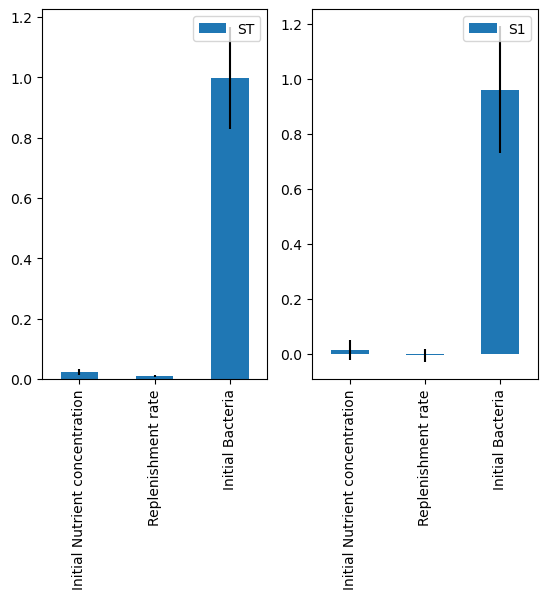

In [84]:
Si.plot()